# Tests for the `cosmo` software package calculations/error model

Here, we test the accuracy of the calculations and error model implemented within the `cosmo` software suite (<a href=''>Marquez and Tissot, 2022</a>). 

## 1. Monte Carlo Simulations

### 1.1. Setup

Here, we use the 130-135 spike combination presecribed by the `cosmo.m` function (~85%-15% of $^{130}Ba$ and $^{135}Ba$ ORNL spikes), with a 50% splitting and 50% spike proportion. 

In [1]:
cd ..
dsstartup;
global ISODATA;

Welcome to the double spike toolbox.    John F. Rudge 2009-2022.
Default parameters are stored in the global variable ISODATA.
Type "global ISODATA" to access and set these parameters.


In [2]:
% INPUT parameters
element='Ba';
prop=0.5;
split=0.5;
spike=[0.319548 0.007732 0.030946 0.194053 0.049874 0.056732 0.341114];
cycles=40;

% fractionation factors
alpha=0.035; % equivalent to 1‰ in 138/134 Ba
beta=1.75;   % instrumental frac. from Table 3 Albarede et al. (2015) closest to mass of Ba isotopes

Here, we run the `shake.m` function in order to (1) introduce the error model on the standard/unspiked measurement (by default, this is set at 0 for the original Double Spike Toolbox), and (2) modify the voltage of the sample in the error model.

For this test, we choose to have 40 cycles each for both IC (unspiked) and ID (spiked) measurement, wherein the sample corresponds to ~10V beam total. This means that the IC measurement shows 10 V per integraion, while the ID measurement shows 10/(1-prop) V/integration.

Below, we can calculate the equivalent sample amount (in ng) to reflect our intended measurement scenario:

$$ng\ sample = \frac{U\cdot t\cdot MM_{Ba}}{e\cdot R_{ref}\cdot Av.}\times\frac{1}{eff}$$

In [3]:
% constants
elementarycharge=1.60217646e-19;  % Coulombs
Avn=6.0221409e+14;   % Avogadro's number (nmol^-1)
MM=sum(ISODATA.(element).standard.*ISODATA.(element).mass); % molar mass of element

U=800; % volts
deltat=8; % seconds
R_ref=1e11; % ohms
eff=0.01; % ionization efficiency 

ng_sample=U*deltat*MM/(elementarycharge*R_ref*Avn)/eff


ng_sample =

    9.1091



In this scenario, we are dealing with ~9 ng of Ba. This is relatively low compared to most applications (typically 30 ng in seawater, <a href="https://doi.org/10.1016/j.epsl.2015.07.027">Horner et al., 2015</a>) and is thus a good example for the an application where the splitting would be an important parameter to consider. 

Using these parameter values, we run the shake.m function to setup our simulation:

In [4]:
R=[1e11 1e11 1e11 1e11 1e11 1e11 1e11;
   1e11 1e11 1e11 1e11 1e11 1e11 1e11];
     
T=300; % temperature of the resistor/faraday cup; in Kelvin

shake(element,ng_sample,[eff eff],[cycles cycles],R,R_ref,T,deltat)

We can now check if the error model for the measurement reflects the fact that the sample represents 10V of each cycle of measurement.

In [5]:
ISODATA.(element).errormodel
ISODATA.(element).errormodel.measured
ISODATA.(element).errormodel.standard


ans = 

  struct with fields:

    measured: [1x1 struct]
       spike: [1x1 struct]
    standard: [1x1 struct]
        V100: 80000


ans = 

  struct with fields:

         type: 'fixed-sample'
    intensity: 10
            a: [1x7 double]
            b: [1x7 double]
            c: [0 0 0 0 0 0 0]
          eff: 0.0100
       cycles: 40


ans = 

  struct with fields:

         type: 'fixed-sample'
    intensity: 10
            a: [1x7 double]
            b: [1x7 double]
            c: [0 0 0 0 0 0 0]
          eff: 0.0100
       cycles: 40



We see here that indeed error model for Ba has been updated successfuly. 

### 1.2. Generating artifical beam voltages using a monte carlo simulation

In order to test whether the predicted errors from `cosmo` are indeed accurate, we generate simulated beams using a monte carlo simulation. One of the important parameters taken into account by `cosmo` is the uncertainty added by internal normalization. While indeed, the uncertainty from the normalizing isotopes is propagated into the final $\sigma_{\alpha}$, this added error is far less compared to the natural fluctuations we see in the instrumental fractionation, $\beta$.

For example, we assume that beta varies with RSD = 0.025 throughout the run (based on the typical uncertainty reported in Table 3 by <a href="https://doi.org/10.1039/C5JA00188A">Alberede et al. (2015)</a>. A separate array was simulated for the IC and ID measurements. 

In [6]:
RSD = 0.025;
beta_arrayIC = normrnd(beta,2*RSD,1,cycles); % different beta values per cycle on IC
beta_arrayID = normrnd(beta,2*RSD,1,cycles); % different beta values per cycle on ID

In [7]:
d=135; % denominator/reference isotope
d=ISODATA.(element).isoindex(d); % get index of denominator isotope

standard=ISODATA.(element).standard; % standard composition
standardR=standard./standard(d); % standard ratios using reference d isotope

mass=ISODATA.(element).mass; % isotope masses
massR=mass./mass(d); % isotope mass ratios using reference d isotope

fracR=standardR.*(massR.^alpha); %fractionated ratios, using exponential law
frac=fracR./sum(fracR); %fractionated composition


spikeV=spike.*ISODATA.Ba.errormodel.spike.intensity %voltages from spike
fracV=frac.*ISODATA.Ba.errormodel.standard.intensity %voltages from fractionated natural samples
mixV=fracV+spikeV %voltage measured with mixture


spikeV =

    3.1955    0.0773    0.3095    1.9405    0.4987    0.5673    3.4111


fracV =

    0.0106    0.0101    0.2415    0.6588    0.7851    1.1231    7.1709


mixV =

    3.2061    0.0874    0.5509    2.5993    1.2839    1.6904   10.5820



We can then calculate the variance for individual beams based on Johnson noise and counting statistics (parameters `a` and `b` from the `errormodel`, respectively):

In [8]:
a=ISODATA.Ba.errormodel.standard.a;
b=ISODATA.Ba.errormodel.standard.b;

mixVariance=a+b.*mixV;
mixSD=sqrt(mixVariance); % also the variance in the ID measurement

fracVariance=a+b.*fracV;
fracSD=sqrt(fracVariance); % also the variance in the IC measurement

Below, we create 2 arrays, each containing 40 rows of measurements:
1. `measuredV` - the voltages of each isotope in the spiked (ID) measurement; each isotope has an uncertainty based on a normal distribution with a $1\sigma$ from `mixSD`. 
2. `standardV` - the voltages of each isotope in the unspiked (IC) measurement; each isotope has an uncertainty based on a normal distribution with a $1\sigma$ from `fracSD`. 

For both arrays, each cycles is fractionated further with an instrumental mass fractionation, $\beta$, from their respective simulated arrays, `beta_arrayIC` and `beta_arrayID`.

In [9]:
measuredV=[];
standardV=[];

for i=1:cycles
    mixunfracV=normrnd(mixV,mixSD); % generating voltages with variance from normal dist. 
    mixunfracR=mixunfracV./mixunfracV(d); % calculating ratios
    
    mixfracR=mixunfracR.*(massR.^beta_arrayID(i)); % fractionating ratios in the instrument
    mixfracV=mixfracR./sum(mixfracR)*sum(mixunfracV);
    
    measuredV(i,:)=mixfracV;
    
    stdunfracV=normrnd(fracV,fracSD); % generating voltages with variance from normal dist. 
    stdunfracR=stdunfracV./stdunfracV(d); % calculating ratios
    
    stdfracR=stdunfracR.*(massR.^beta_arrayIC(i)); % fractionating ratios in the instrument
    stdfracV=stdfracR./sum(stdfracR)*sum(fracV);
    
    standardV(i,:)=stdfracV;
end

Checking that the total beam voltages per cycle are correct

In [10]:
mean(sum(measuredV,2))


ans =

   20.0000



In [11]:
mean(sum(standardV,2))


ans =

    10



### 1.3. Processing the Monte Carlo simulation data

#### 1.3.1. Spiked Data

In [12]:
alphaID=[]; %alpha values calculated per cycle
betaID=[]; %beta values calculated per cycle

isoinv=[130 134 135 138];

for i=1:length(measuredV)
    out=dsinversion(element,measuredV(i,:),spike,isoinv);
    
    alphaID(i)=out.alpha;
    betaID(i)=out.beta;
end

Checking that indeed we get the average values expected ($\mu_{\alpha} = 0.035$ and $\mu_{\beta} = 1.75$ as set in **Section 1.1**).

In [13]:
mean(alphaID)


ans =

   -0.0349



Note that this is negative because of the definition of $\alpha$ in Rudge et al. (2009).

In [14]:
mean(betaID)


ans =

    1.7495



Next, we calculate 1SE for $\alpha$ from these monte carlo runs:

In [15]:
alpha1SD = std(alphaID)/sqrt(cycles)


alpha1SD =

   6.1044e-04



Just to check, the uncertainty estimated for the spiked measurement when the covariance matrix for the standard, $V_m = 0$ (*i.e.*, no uncertainty on the standard composition) should be similar.

In [16]:
% setting the standard/unspiked measurement uncertainty to zero
ISODATA.(element).errormodel.standard.a=zeros(1,7);
ISODATA.(element).errormodel.standard.b=zeros(1,7);

% calculating the resulting error with ID as the only source of uncertainty
errorwsplit('Ba',0.5,0.5,spike,isoinv)

%returning the standard error model
shake(element,ng_sample,[eff eff],[cycles cycles],R,R_ref,T,deltat)


ans =

   7.0949e-04



Indeed, we see that the uncertainty calculated from the `errorwsplit.m` function is very similar to the resulting uncertainty we observe in our Monte Carlo simulation. 

Next, we can check what the uncertainty would be for out Monte Carlo ID data when we use our simulated IC data as a standard for the inversion:

In [17]:
alphaID2=[]; %alpha values calculated per cycle
betaID2=[]; %beta values calculated per cycle

isoinv=[130 134 135 138];

for i=1:length(measuredV)
    out=dsinversion(element,measuredV(i,:),spike,isoinv,standardV(i,:));
    
    alphaID2(i)=out.alpha;
    betaID2(i)=out.beta;
end

In [18]:
alpha1SD2 = std(alphaID2)/sqrt(cycles)


alpha1SD2 =

    0.0110



Note that the uncertainty is substantially bigger compared to the data wherein the standard was set to have no uncertainty. If we then examine the uncertainty predicted by `errorwsplit.m`, we see something interesting:

In [19]:
errorwsplit('Ba',0.5,0.5,spike,isoinv)


ans =

   8.6610e-04



While this estimate is bigger than the error when the model assumes no uncertainty on the standard, it is orders of magnitude lower compared to the uncertainty we see in the Monte Carlo simulated data. 

This is because the additional uncertainty in the Monte Carlo beams is a compounded effect of:
1. The fluctuations of individual beam uncertainties from counting statistics and Johnson noise.
2. The fluctuations in instrumental mass fractionation, $\beta$.

The latter is much bigger than the former, and is not taken into account in the simulation (there is no way to introduce large fluctuations in $\beta$ for calculations in the DS Toolbox - this is a natural limitation of estimating uncertainties analytically).

#### The importance of internal normalization

This scenario highlights the importance of internal normalization - <u> while it introduces additional uncertainty, it is still preferred to apply such a normalization in order to eliminate the large fluctuations inherent in the instrument. </u> It is then the goal of the `cosmo` software package to identify the internal normalization schemes that would result to minimal additional uncertainties.

Note that the uncertainty on a spiked measurement that takes into account the uncertainty of an *internally-normalized unspiked measurement* is analytically-predictable (and is exactly what `cosmo` does!).

#### 1.3.2. Unspiked Data


In order to propagate the uncertainty from the internally-normalized standard/sample measurement into the final uncertainty on $\alpha$, here we need to convert $\sigma_{\alpha}$ of the spiked measurement into the RSD of a ratio, which here we choose to be $^{137}Ba/^{135}Ba$. From Eq. 6 in Appendix A of Rudge et al. (2009):

$$n_i=N_i\cdot e^{\alpha P_i}$$ 

The RSD for the ratio $n_i$ would then be:

$$RSD_{n_i}=P_i\cdot \sigma_{\alpha}$$

In [20]:
ratisos = [137 135]; % choice of isotope ratios to use - second isotope is the denominator
ratisos = ISODATA.(element).isoindex(ratisos); 

P=log(ISODATA.(element).mass/ISODATA.(element).mass(ratisos(2)));

RSD_75=P(ratisos(1))*alpha1SD % RSD on the 137/135 ratio


RSD_75 =

   8.9841e-06



This will then be combined later with the RSD of the same ratio from the standard/unspiked measurement in order to achieve the final uncertainty on $\alpha$.

Here, we process the simulated unspiked measurement (`standardV`). Here, we choose one particular ratio for the internal normalization (`INisos` - [j k]), from which we calculate the $\zeta$ using the following equation (Eq. 7 in <a href=https://doi.org/10.1039/C7JA00187H>Hu and Dauphas</a>: 

$$\zeta = \ln\left(\frac{r_{smp}^{j/k}}{R_{ref}^{j/k}}\right)\bigg/\ln\left(\frac{m_j}{m_k}\right)$$

In [21]:
% Specifying internal normalization ratio and calculating this ratio per cycle
INisos=[138 135];
INisos=ISODATA.Ba.isoindex(INisos);

% Calculating all ratios - using the same denominator as in ratisos
R=standardV./standardV(:,INisos(2));

% Calculating ratios used for internal normalization
R_samp=standardV(:,INisos(1))./standardV(:,INisos(2));

INrat_ref=ISODATA.(element).standard(INisos(1))/ISODATA.(element).standard(INisos(2)); %reference ratio
massrat_ref=P(1,INisos(1)); %ln(m_j/m_k)

% Calculating zeta
zeta=(log(R_samp./INrat_ref))/massrat_ref;
zeta=repmat(zeta,1,ISODATA.(element).nisos);

% Matrix of P_i vals
P_mat=repmat(P,length(R),1);

% Calculating internally normalized ratios
RIN=R.*exp(-P_mat.*zeta); 

We can now calculate the 1SE on the $^{137}Ba/^{135}Ba$ ratio for the **internally-normalized** unspiked measurement:

In [22]:
Ba_75_1SD=std(RIN(:,ratisos(1)))/sqrt(cycles); %1SD
RSD_75Std=Ba_75_1SD/mean(RIN(:,ratisos(1)))


RSD_75Std =

   7.8123e-06



#### 1.3. Combining Uncertainties

The $\delta^{\prime}_{137/135}$ value is defined as:

$$\delta^{\prime}_{137/135} = \ln\left(\frac{r_{smp}^{137/135}}{R_{std}^{137/135}}\right)\times 1000$$

From Eq. 48 in Rudge et al. (2009), we know that:

$$\delta^{\prime}_{137/135} = \alpha P_i\times 1000$$

We can then re-write:
$$\alpha = \frac{1}{P_i}\ln\left(\frac{r_{smp}^{137/135}}{R_{std}^{137/135}}\right)$$

As such, the uncertainty on $\alpha$ if both $r_{smp}$ and $R_{std}$ have errors can be written as:
$$\sigma_{\alpha} = \frac{1}{P_i}\sqrt{RSD_{r_{smp}}^2+RSD_{R_{std}}^2}$$

In [23]:
1/log(137/135)*hypot(RSD_75,RSD_75Std)


ans =

   8.0957e-04



We can then check if this is close the error estimate that we get from `errorwsplit.m` assuming the same sample amount and measurement parameters:

In [24]:
errorwsplit('Ba',0.5,0.5,spike,isoinv,INisos)


ans =

   9.2459e-04



Note the similarities in the estimated uncertainties. Next, we examine if changing the internal normalization scheme for processing the data leads to a similar increase in uncertainty as predicted by `errorwsplit.m`. 

### 1.4. Effect of normalization

Here, we test what happens when we choose a different normalization for the same data set. Here, we normalize to the $^{134}Ba/^{135}Ba$ ratio.

In [25]:
% Specifying internal normalization ratio and calculating this ratio per cycle
INisos=[134 135];
INisos=ISODATA.Ba.isoindex(INisos);

% Calculating all ratios - using the same denominator as in ratisos
R=standardV./standardV(:,INisos(2));

% Calculating ratios used for internal normalization
R_samp=standardV(:,INisos(1))./standardV(:,INisos(2));

INrat_ref=ISODATA.(element).standard(INisos(1))/ISODATA.(element).standard(INisos(2)); %reference ratio
massrat_ref=P(1,INisos(1)); %ln(m_j/m_k)

% Calculating zeta
zeta=(log(R_samp./INrat_ref))/massrat_ref;
zeta=repmat(zeta,1,ISODATA.(element).nisos);

% Matrix of P_i vals
P_mat=repmat(P,length(R),1);

% Calculating internally normalized ratios
RIN=R.*exp(-P_mat.*zeta); 

In [26]:
Ba_75_1SD=std(RIN(:,ratisos(1)))/sqrt(cycles); %1SD
RSD_75Std=Ba_75_1SD/mean(RIN(:,ratisos(1)))


RSD_75Std =

   4.0666e-05



Notice that the RSD on the $^{137}Ba/^{135}Ba$ ratio is almost an order of magnitude higher - this makes sense, given that we are using a less abundant isotope in $^{134}Ba$ for normalization, which would have a larger uncertainty from shot noise. 

Re-preforming the propagation on $\sigma_{\alpha}$:

In [27]:
1/log(137/135)*hypot(RSD_75,RSD_75Std)


ans =

    0.0028



In [28]:
errorwsplit('Ba',0.5,0.5,spike,isoinv,INisos)


ans =

    0.0024



Again, we see that `cosmo.m` closely predicts the change in uncertainty associated with a change in the internal-normalization isotopes. 

Below, we can also plot the values for the non-normalized ratios (`R`) vs. that of the internally-normalized ratios (`RIN`). Notice the larger variance for the latter. 

### 1.4. A Final Word (and err, Graph) on Internal Normalization

As mentioned earlier, <u>**the whole point of internal normalization is to eliminate the fluctuations associated with mass-dependent fractionation in the instrument during measurement, which is far larger that the predicted uncertainties from counting statistics and Johnson Noise.**</u> 

Below we can plot the ratios calculated above for a (1) non-normalized set of measurements (`R`) and (2) internally-normalized set of measurements (`RIN`). It is immediately clear that the fluctuations in the former are much larger than the latter. Also, note that the two plots have different average values. The internally-normalized ratios have an average value close to that of the standard composition ($\approx 1.7039$), while the non-normalized ratio is offset by a factor $\left(\frac{m_j}{m_k}\right)^{\zeta} = \left(\frac{m_j}{m_k}\right)^{\alpha+\beta} = 1.027$. 

In [29]:
% internally-normalized data
std75=ISODATA.Ba.standard(6)/ISODATA.Ba.standard(4) % standard 137/135 ratio
mean75IN=mean(RIN(:,ratisos(1))) % mean of internally-normalized data

% non-normalized data
frac75=std75*(ISODATA.Ba.mass(6)/ISODATA.Ba.mass(4))^(alpha+beta)
mean75=mean(R(:,ratisos(1)))


std75 =

    1.7039


mean75IN =

    1.7038


frac75 =

    1.7492


mean75 =

    1.7497



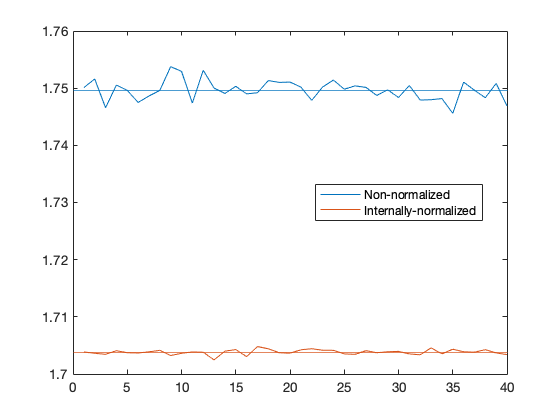

In [30]:
plot(1:length(R),R(:,ratisos(1)),'Color',[0 0.4470 0.7410]);
hold on
plot(1:length(RIN),RIN(:,ratisos(1)),'Color',[0.8500 0.3250 0.0980])
yline(mean75,'Color',[0 0.4470 0.7410]);
yline(mean75IN,'Color',[0.8500 0.3250 0.0980]);
hold off
legend('Non-normalized','Internally-normalized','Location','best')

The difference in the extent of fluctuations is further illustrated when we remove the offset from the non-normalized ratios (blue) by dividing it with an absolute value (here we use 1.027) and plot it against the internally-normalized ratios (orange).

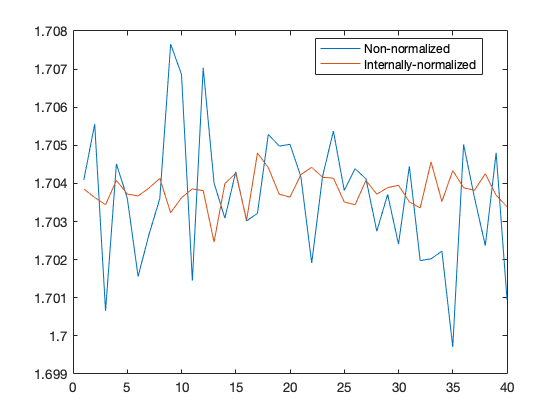

In [31]:
plot(1:length(R),R(:,ratisos(1))./1.027,'Color',[0 0.4470 0.7410]);
hold on
plot(1:length(RIN),RIN(:,ratisos(1)),'Color',[0.8500 0.3250 0.0980])

hold off
legend('Non-normalized','Internally-normalized','Location','best')

## 2. Comparison with Hu & Dauphas (2017)

Here, we compare the estimated uncertainties associated with correcitng for the offsets introduced by isotope anomalies on the resulting value for $\alpha$.

We use the 130-137 spike combination presecribed by the `cosmo.m` function (~49%-51% of $^{130}Ba$ and $^{137}Ba$ ORNL spikes, respectively), with a 50% splitting and 50% spike proportion. 

In [32]:
% re-starting the DS Toolbox
dsstartup;
global ISODATA;

Welcome to the double spike toolbox.    John F. Rudge 2009-2022.
Default parameters are stored in the global variable ISODATA.
Type "global ISODATA" to access and set these parameters.


In [33]:
% INPUT parameters
element='Ba';
prop=0.5;
split=0.5;
spike=[0.182797 0.004525 0.017545 0.031156 0.030334 0.452349 0.281295];
cycles=40;

deltat=8; % seconds
R_ref=1e11; % ohms
R=[1e11 1e11 1e11 1e11 1e11 1e11 1e11; 1e11 1e11 1e11 1e11 1e11 1e11 1e11];
     
sample=1; % ng
     
effIC = 0.01; % ionization efficiency of the IC measurement
effID = 0.01; % ionization efficiency of the ID measurement
T     = 300; % temperature of the resistor/faraday cup; in Kelvin

shake(element,sample,[effIC effID],[cycles cycles],R,R_ref,T,deltat)

We then check the equivalent voltage with these parameters.

In [34]:
ISODATA.Ba.errormodel.V100


ans =

   8.7825e+03



With the expected splitting, ionization efficiency, and number of cycles, we can calculate the expect voltage per integration:

In [35]:
V=ISODATA.Ba.errormodel.V100*split*effID/cycles


V =

    1.0978



We can then use this as the voltage for estimating the uncertainty for the double spike measurement without accounting for the uncertainty on any unspiked measurement:

In [36]:
% resetting the DS Toolbox by removing the parameters from shake
dsstartup;
global ISODATA;
ISODATA.Ba.errormodel.measured.type='fixed-sample';

ISODATA.Ba.errormodel.measured.intensity = V;
ID=errorestimate('Ba',prop,spike,[130 135 137 138])/sqrt(cycles)

Welcome to the double spike toolbox.    John F. Rudge 2009-2022.
Default parameters are stored in the global variable ISODATA.
Type "global ISODATA" to access and set these parameters.

ID =

    0.0021



Next, we calculate the additional uncertainty from the unspiked measurement according to the formula from <a href="https://doi.org/10.1039/C7JA00187H">Hu and Dauphas (2017)</a>. The offset introduced by isotope anomalies, $d\alpha$, can be calculated using the Eq. 14 from this paper:

$$d\alpha = -\frac{1}{10^4}\frac{\begin{vmatrix}\varepsilon_{2/1} & \varepsilon_{3/1} & \varepsilon_{4/1}\\
t_{2/1} & t_{3/1} & t_{4/1}\\
\left(t_{2/1}+\frac{1}{f}\right)\mu_{2/1} & \left(t_{3/1}+\frac{1}{f}\right)\mu_{3/1} & \left(t_{4/1}+\frac{1}{f}\right)\mu_{4/1}\\
\end{vmatrix}}{\begin{vmatrix}\mu_{2/1} & \mu_{3/1} & \mu_{4/1}\\
t_{2/1} & t_{3/1} & t_{4/1}\\
t_{2/1}\mu_{2/1} & t_{3/1}\mu_{3/1} & t_{4/1}\mu_{4/1}\\
\end{vmatrix}}$$

which can then be re-written with the shorthand notation:

$$d\alpha = -\frac{1}{10^4D}\cdot\left(F_{2/1}\varepsilon_{2/1}+F_{3/1}\varepsilon_{3/1}+F_{4/1}\varepsilon_{4/1}\right)$$

where F_{i/1} represent cofractors of the numerator matrix, while $D$ is the determinant of the denominator matrix. The additional uncertainty associated with $d\alpha$ is then: 

$$\sigma_{d\alpha}=-\frac{1}{10^4D}\cdot \sqrt{\left(F_{2/1}\sigma_{\varepsilon_{2/1}}\right)^2+\left(F_{3/1}\sigma_{\varepsilon_{2/1}}\right)^2+\left(F_{4/1}\sigma_{\varepsilon_{2/1}}\right)^2}$$

$\sigma_{d\alpha}$ is the first output from the function `addederror.m`, which implements the formula shown here. Note that this added uncertainty from the correction of $d\alpha$ is not directly dependent on the value of $\varepsilon_{i/1}$, but rather its uncertainty, which can be theoretically calculated using the error model already built into the DS Toolbox's `ISODATA` sturcture. 

In [37]:
% re-introducing the additional parameters from shake
shake(element,sample,[effIC effID],[cycles cycles],R,R_ref,T,deltat)

% here, we use a normalization to the 134/138 ratio
IC=addederror('Ba',split,prop,spike,[130 135 137 138],[134 138])


IC =

    0.0036



The total uncertainty on $\alpha$ is then the quadratic sum of the ID and IC measurement uncertainties:

$$\sigma_{\alpha}^{corr} = \sqrt{\left(\sigma_{\alpha}^{uncorr}\right)^2 + \left(\sigma_{d\alpha}\right)^2}$$

In [38]:
sigma_alpha=hypot(ID,IC)


sigma_alpha =

    0.0042



We can then compare this result to the estimate using `errorwsplit.m` directly:

In [39]:
errorwsplit('Ba',split,prop,spike,[130 135 137 138],[134 138])


ans =

    0.0043



The uncertainties are almost exactly the same. We can try a different normalization scheme to check.

In [40]:
IC2=addederror('Ba',split,prop,spike,[130 135 137 138],[138 130])
sigma_alpha2=hypot(ID,IC2)


IC2 =

    0.0317


sigma_alpha2 =

    0.0318



In [41]:
errorwsplit('Ba',split,prop,spike,[130 135 137 138],[138 130])


ans =

    0.0333

